In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
from pathlib import Path
import matplotlib.pyplot as plt


In [2]:
#setting Path
image_dir = Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

#get filepaths of all files
filepaths = list(image_dir.glob(r'**/*.png'))


In [3]:
data = []
#To get filepaths and label
for i in range(len(filepaths)):
    label = os.path.split(os.path.split(filepaths[i])[0])[1]
    data.append([str(filepaths[i]), label])

#creating DataFrame
df = pd.DataFrame(data, columns=['path', 'label'])
#droping Non Ground truths
df = df[df['label'].apply(lambda x: x[-2:] != "GT")].reset_index(drop = True)

In [4]:
#classes
df.label.unique()

array(['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet',
       'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream',
       'Red Sea Bream'], dtype=object)

In [5]:
#getting 9 images of each class
fish_all = list(df.path.loc[0:8]) + list(df.path.loc[1000:1008]) + list(df.path.loc[2000:2008]) + list(df.path.loc[3000:3008]) + list(df.path.loc[4000:4008]) +list(df.path.loc[5000:5008]) + list(df.path.loc[6000:6008]) + list(df.path.loc[7000:7008]) + list(df.path.loc[8000:8008])

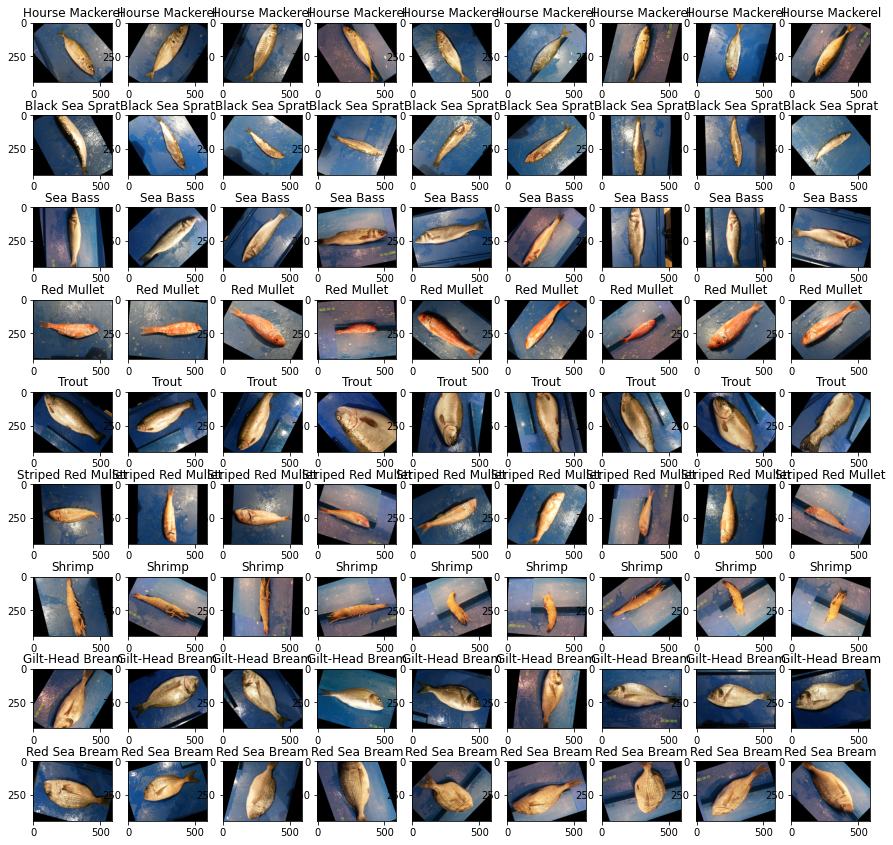

In [6]:
#A pyPlot for all class Images
fig, axes = plt.subplots(nrows = 9, ncols = 9, figsize = (20,20))
for index, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(fish_all[index]))
    ax.set_title(os.path.split(os.path.split(fish_all[index])[0])[1])

In [7]:
#checking Null values
df.isnull().any()

path     False
label    False
dtype: bool

In [8]:
#Dividing Data into Train, Test, and Validation
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size = 0.1, random_state = 42)
train_data.count()
test_data.count()

path     900
label    900
dtype: int64

In [9]:
from keras.preprocessing.image import ImageDataGenerator
#Handling Image data Generators
train_data_gen = ImageDataGenerator(validation_split=0.25)
test_data_gen = ImageDataGenerator()

train_imgs = train_data_gen.flow_from_dataframe(dataframe=train_data, x_col='path', y_col='label', target_size=(224,224),class_mode="categorical", color_mode='grayscale',batch_size=24, shuffle=True,subset="training")
val_imgs = train_data_gen.flow_from_dataframe(dataframe=train_data, x_col='path', y_col='label', target_size=(224,224), class_mode="categorical", color_mode='grayscale',batch_size=24, shuffle=True,subset="validation")

test_imgs = test_data_gen.flow_from_dataframe(dataframe=test_data,x_col='path', y_col='label', target_size=(224,224), class_mode="categorical", color_mode='grayscale',batch_size=24, shuffle=False)

Found 6075 validated image filenames belonging to 9 classes.
Found 2025 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [10]:
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten,MaxPooling2D, InputLayer

In [11]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=(224,224,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(9))
model.add(Activation('softmax'))

In [12]:
from tensorflow.keras.optimizers import *
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics = ['accuracy', 'AUC'])

In [14]:
history = model.fit( train_imgs, validation_data=val_imgs, epochs=10)

Epoch 1/10
254/254 [==============================] - 170s 643ms/step - loss: 54.6180 - accuracy: 0.2943 - auc: 0.6943 - val_loss: 0.6914 - val_accuracy: 0.7610 - val_auc: 0.9752
Epoch 2/10
254/254 [==============================] - 76s 298ms/step - loss: 0.5028 - accuracy: 0.8179 - auc: 0.9824 - val_loss: 0.2817 - val_accuracy: 0.9116 - val_auc: 0.9949
Epoch 3/10
254/254 [==============================] - 75s 297ms/step - loss: 0.2048 - accuracy: 0.9274 - auc: 0.9967 - val_loss: 0.2199 - val_accuracy: 0.9289 - val_auc: 0.9958
Epoch 4/10
254/254 [==============================] - 75s 296ms/step - loss: 0.1062 - accuracy: 0.9658 - auc: 0.9985 - val_loss: 0.1393 - val_accuracy: 0.9501 - val_auc: 0.9977
Epoch 5/10
254/254 [==============================] - 75s 297ms/step - loss: 0.0814 - accuracy: 0.9728 - auc: 0.9983 - val_loss: 0.0889 - val_accuracy: 0.9704 - val_auc: 0.9987
Epoch 6/10
254/254 [==============================] - 75s 297ms/step - loss: 0.0443 - accuracy: 0.9834 - auc: 0.9

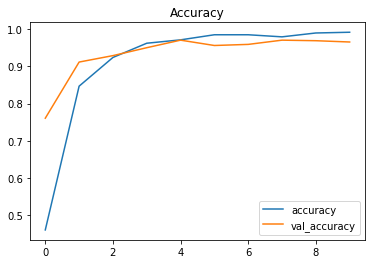

In [15]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

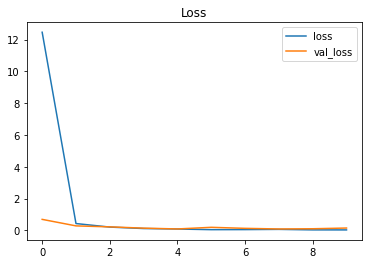

In [16]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

In [17]:
prediction = model.predict(test_imgs)

In [18]:
#train_imgs.class_indices

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [32]:
output = np.argmax(prediction, axis=1)
labels = test_imgs.class_indices
print(labels)
print(type(labels))
pred_labels = dict((v,k) for k,v in labels.items())
print(pred_labels)
print(type(pred_labels))

{'Black Sea Sprat': 0, 'Gilt-Head Bream': 1, 'Hourse Mackerel': 2, 'Red Mullet': 3, 'Red Sea Bream': 4, 'Sea Bass': 5, 'Shrimp': 6, 'Striped Red Mullet': 7, 'Trout': 8}
<class 'dict'>
{0: 'Black Sea Sprat', 1: 'Gilt-Head Bream', 2: 'Hourse Mackerel', 3: 'Red Mullet', 4: 'Red Sea Bream', 5: 'Sea Bass', 6: 'Shrimp', 7: 'Striped Red Mullet', 8: 'Trout'}
<class 'dict'>


In [33]:
labeled_pred = []
for i in range(0, len(output)):
    labeled_pred.append(pred_labels[output[i]])

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
print(classification_report(test_data['label'], labeled_pred))
print(confusion_matrix(test_data.label, labeled_pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.94      0.98      0.96       121
   Gilt-Head Bream       0.94      0.90      0.92       108
   Hourse Mackerel       0.91      0.95      0.93        96
        Red Mullet       0.93      0.96      0.94        79
     Red Sea Bream       1.00      0.96      0.98        91
          Sea Bass       0.96      0.99      0.98        99
            Shrimp       0.93      0.98      0.95       103
Striped Red Mullet       0.96      0.95      0.95       100
             Trout       0.95      0.84      0.89       103

          accuracy                           0.94       900
         macro avg       0.95      0.94      0.94       900
      weighted avg       0.95      0.94      0.94       900

[[118   0   0   0   0   0   0   0   3]
 [  2  97   0   2   0   0   1   4   2]
 [  0   1  91   0   0   0   4   0   0]
 [  1   2   0  76   0   0   0   0   0]
 [  1   1   0   0  87   0   2   0   0]
 [  1   0   0   0   0 

In [36]:
model.evaluate(test_imgs)[1]

38/38 [==============================] - 9s 235ms/step - loss: 0.1943 - accuracy: 0.9444 - auc: 0.9942


0.9444444179534912